In [47]:
import pandas as pd
import numpy as np

input_file = "obj/Astec/cells_rot_inv_rep.csv"
cdf = pd.read_csv(input_file)

#print(cdf.head())

t_min = int(cdf['fr'].min())
t_max = int(cdf['fr'].max())
t_range = range(t_min, t_max)

print(t_range)

cols = [f"S{i}" for i in range(21)]

range(0, 158)


In [48]:
lineage_file = "obj/Astec/cellLineage.csv"
ldf = pd.read_csv(lineage_file, sep=" ")

#print(ldf.head())

ids = []
ldfsFr = []
rev_ids = []

nb_cells = np.zeros(len(t_range)+1)
cumul_cells = np.zeros(len(t_range)+1)

for fr in t_range:
    ldfsFr = ldf[ldf['fr'] == (fr+1)]#+50
    ids_fr = np.unique(ldfsFr['id'].values)
    nb_cells[fr+1] = len(ids_fr)
    ids += [ids_fr]
    cumul_cells[fr+1] = cumul_cells[fr] + len(ids_fr)
    #cumul_cells[fr] += [fr]

    #print(ids[fr])
    arr = np.zeros(1+np.max(ids[fr]))
    rev_ids += [arr]

    for i in range(len(ids[fr])):
        rev_ids[fr][ids[fr][i]] = i

#print(nb_cells)

In [49]:
print(t_min, t_max)

lin_max = [1,2,4]#,8]
ds = np.zeros((t_max+1, int(nb_cells[t_max]), len(lin_max), np.max(lin_max)))
ds[:,:,:,:] = np.nan

ldf_all_t = [ldf[ldf['fr'] == t+1] for t in t_range]#+50
for h in range(0,len(lin_max)):
    for t in range(lin_max[h]-1, t_max):#+1):
        for cell in range(int(nb_cells[t+1])):
            n = 0
            ds[t,cell,h,n] = cell
            for tau in range(t-1,t-lin_max[h],-1):
                child = ds[t,cell,h,n]
                
                ldf_tau = ldf_all_t[tau]
                #print(ldf_tau)
                prt = ldf_tau['id'][ldf_tau['ch'] == ids[tau+1][int(child)]]
                #print(prt)
                #cdfs_tau = cdfs_all_t[tau]
                #prt = cdfs_tau[(cdfs_tau['ch1'] == child) | (cdfs_tau['ch2'] == child)]['id']
                if(len(prt) > 0):
                    prt = rev_ids[tau][prt.iloc[0]]
                    ds[t,cell,h,n+1] = prt
                else:
                    ds[t,cell,h,n+1] = -1
                n = n+1

0 158


In [50]:
lineage = np.zeros((int(nb_cells[1]), t_max+1,32))
lineage[:,:,:] = np.nan
lineage[:,0,0] = range(0, int(nb_cells[1]))

t_range = range(t_min, t_max)

Sf = cdf[cols].values
Sf_p = np.zeros(Sf.shape)
Vf_p = np.zeros(Sf.shape)

print(np.sum(Sf[0:112, :]))
print(np.sum(Sf[112:224, :]))
print(np.sum(Sf[224:336, :]))

for t in range(0, len(t_range)-1):
    for cell in range(0, int(nb_cells[1])):
        
        lin_cell_t = lineage[cell,t,:][~np.isnan(lineage[cell,t,:])].astype(int)
        lin_cell_tpp = np.array(ldf[ldf['fr'] == t+1][ldf['id'].isin(ids[t][lin_cell_t])]['ch'])#+50

        lin_cell_tpp = lin_cell_tpp[lin_cell_tpp < len(rev_ids[t+1])]
        lineage[cell,t+1,0:len(lin_cell_tpp)] = rev_ids[t+1][lin_cell_tpp]

for t in range(0, len(t_range)):
    for cell in range(0, int(nb_cells[1])):
        lin = lineage[cell,t,:]
        rng = lin[~np.isnan(lin)].astype(int)
        
        #print(t, cumul_cells[t], rng)
        for i in rng:
            Sf_p[int(cumul_cells[t])+i, :] = (Sf[int(cumul_cells[t])+i, :] - Sf[cell, :])

#Sf = Sf_p
print(Sf.shape)
print(np.sum(Sf[0:112, :]))
print(np.sum(Sf[112:224, :]))
print(np.sum(Sf[224:336, :]))

#print(lineage)

159.381976
155.71207199999995
154.16703100000004


<ipython-input-50-2d706a3e3acd>:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lin_cell_tpp = np.array(ldf[ldf['fr'] == t+1][ldf['id'].isin(ids[t][lin_cell_t])]['ch'])#+50


(44000, 21)
159.381976
155.71207199999995
154.16703100000004


In [51]:
#def compute_velocities(Sf):
df_v = np.zeros(Sf.shape)
for t in range(len(t_range)-1):
    for cell in range(0, int(nb_cells[t+1])):
        chdr = ldf[ldf['fr'] == t+1][ldf['id'] == int(ids[t][cell])]['ch']
        ch1 = chdr.iloc[0].astype(int)
        df_v[int(cumul_cells[t]) + cell,:] = (Sf[int(cumul_cells[t+1]) + ch1,:] - Sf[int(cumul_cells[t]) + cell,:])
        
        if len(chdr) > 1:
            ch2 = chdr.iloc[1].astype(int)
            #print(t, ch2)
            df_v[int(cumul_cells[t]) + cell,:] += (Sf[int(cumul_cells[t+1]) + ch2,:] - Sf[int(cumul_cells[t]) + cell,:])
            df_v[int(cumul_cells[t]) + cell,:] = df_v[int(cumul_cells[t]) + cell,:]/2
            
#return df_v

#df_v = compute_velocities(Sf)

#print(Sf.shape, df_v.shape)

""" Sf = np.concatenate((Sf, df_v), axis=1)


df_v = np.zeros(Sf.shape)
for t in range(len(t_range)-1):
    for cell in range(0, int(nb_cells[t+1])):
        chdr = ldf[ldf['fr'] == t+1][ldf['id'] == int(ids[t][cell])]['ch']
        ch1 = chdr.iloc[0].astype(int)
        df_v[int(cumul_cells[t]) + cell,:] = (Sf[int(cumul_cells[t+1]) + ch1,:] - Sf[int(cumul_cells[t]) + cell,:])
        
        if len(chdr) > 1:
            ch2 = chdr.iloc[1].astype(int)
            #print(t, ch2)
            df_v[int(cumul_cells[t]) + cell,:] += (Sf[int(cumul_cells[t+1]) + ch2,:] - Sf[int(cumul_cells[t]) + cell,:])
            df_v[int(cumul_cells[t]) + cell,:] = df_v[int(cumul_cells[t]) + cell,:]/2 """


print(Sf.shape, df_v.shape)

<ipython-input-51-590d71f48d42>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  chdr = ldf[ldf['fr'] == t+1][ldf['id'] == int(ids[t][cell])]['ch']


(44000, 21) (44000, 21)


In [52]:
# Restructure data such that the cell history is taken into account

#Sf.shape[1]

t_range = range(t_min,t_max)
df = np.zeros((len(lin_max), t_max+1, int(nb_cells[t_max]), Sf.shape[1]*np.max(lin_max)))
for h in range(0, len(lin_max)):
    for t in range(lin_max[h]-1, t_max):
        for cell in range(0, int(nb_cells[t+1])):
            rng = range(0,lin_max[h])
            ancestry = ds[t,cell,h,rng].astype(int) #potentially lin_max[h]-1
            
            val2 = np.zeros((lin_max[h], Sf.shape[1]))
            val2[:,:] = np.nan
            
            for prt_id in range(0, len(ancestry)):
                
                tau = t - prt_id
                start = int(cumul_cells[tau])    
                prt = ancestry[prt_id]        
                val2[prt_id, :] = Sf[start+prt,:]
                tau = tau-1
            val2 = val2.reshape(val2.shape[0]*val2.shape[1])
            
            df[h,t,cell,0:len(val2)] = val2.T


In [53]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from colour import Color
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=2)

all_cells = np.arange(int(nb_cells[1]))
#clones = [[0,1], [86,87]]
clone_names = ["all_cells"]

p_t = []
df_h_w0s = []

h=0
p = []
V_dim = lin_max[h]*Sf.shape[1]
all_data = np.zeros((0, V_dim))

#print(min, max)

for t in range(lin_max[h]-1,t_max+1):
    tau = t-(lin_max[h]-1)
    clone = all_cells
    lin = lineage[clone,t,:]
    rng = lin[~np.isnan(lin)].astype(int)
    df_h = df[h,t,rng,0:V_dim]
    #p += [p[tau] + df_h.shape[0]]

    all_data = np.append(all_data, df_h, axis=0)
print(all_data.shape)
#all_data = all_data[~np.isnan(all_data)]

print(all_data.shape)
pca_all_data = pca.fit(all_data)

#df=pd.DataFrame()

(43352, 21)
(43352, 21)


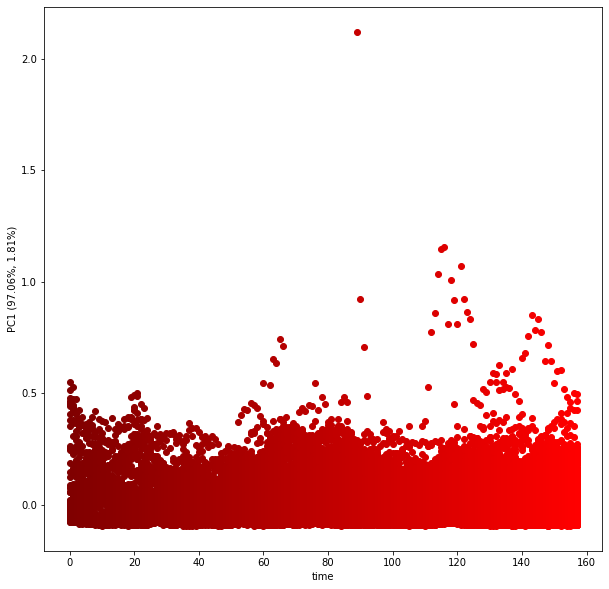

In [54]:
#clones = [[1,2], [110,111]]
#clones = [[0]]
#clones = [all_cells]
#clone = range(0,64)#[20,2]

clones = [all_cells]
for cl in range(0,len(clones)):    
    p_t += [[0]]
    V_dim = lin_max[h]*Sf.shape[1]
    df_h_w0s += [np.zeros((0, V_dim))]

    #print(range(lin_max[h]-1,max+1))
    for t in range(lin_max[h]-1,t_max):#+1
        
        tau = t-(lin_max[h]-1)
        clone = np.array(clones[cl]).astype(int)
        
        lin = lineage[clone,t,:]
        rng = lin[~np.isnan(lin)].astype(int)
        #print(t, lineage[clone,t,:])
        df_h = df[h,t,rng,0:V_dim]
        p_t[cl] += [p_t[cl][tau] + df_h.shape[0]]

        df_h_w0s[cl] = np.append(df_h_w0s[cl], df_h, axis=0)

    #print(t, cl, df_h_w0s[cl].shape)
    

pca_data = []
variance_ratio = []
for cl in range(0,len(clones)):
    
    pca_data += [pca_all_data.transform(df_h_w0s[cl])]
    variance_ratio += [pca_all_data.explained_variance_ratio_]
    #print(pca.explained_variance_ratio_)

red = [(0.5 + 0.5*t/t_max,0,0) for t in range(lin_max[h]-1,t_max, 1)]
green = [(0, 0.5+0.5*t/t_max,0) for t in range(lin_max[h]-1,t_max, 1)]
blue = [(0, 0,0.5+0.5*t/t_max) for t in range(lin_max[h]-1,t_max, 1)]
yellow = [(0.5 + 0.5*t/t_max, 0,0.5+0.5*t/t_max) for t in range(lin_max[h]-1,t_max, 1)]
color_grad = [red, blue, green, yellow]

# Figure
fig = plt.figure(figsize=(10,10))
k=1

for cl in range(0, len(clones)):    
    #ax = fig.add_subplot(5, 3, k,projection='3d')
    ax = fig.add_subplot(1, 1, 1, 
                     #projection='3d'
                     )
    k=k+1

    #plt.title(f"fate={clone_names[cl]} {clones[cl]}")

    #start = 0
    for t in range(lin_max[h]-1,t_max, 1):
    #for t in range(lin_max[h]-1,90, 1):
        tau = t - (lin_max[h]-1)
        lbl = "t=" + str(t)
        #print(len(pca_data[cl][p_t[cl][tau]:p_t[cl][tau+1], 0]))
        ax.scatter(np.ones((len(pca_data[cl][p_t[cl][tau]:p_t[cl][tau+1], 0])))*t,
                    pca_data[cl][p_t[cl][tau]:p_t[cl][tau+1], 0], 
                    #pca_data[cl][p_t[cl][tau]:p_t[cl][tau+1], 1],
                    
                    label = lbl,
                    #color = (t/max, 0, 0)
                    color = color_grad[cl][t]
                    )
        ax.set_xlabel('time')
        pc1 = 100*np.round(variance_ratio[cl][0], 4)
        pc2 = 100*np.round(variance_ratio[cl][1], 4)
        ax.set_ylabel('PC1 (' + str(pc1) + '%, ' + str(pc2) + '%)')
        #ax.set_ylim([-0.01, 0.025])
        #ax.set_zlabel('PC2')

In [55]:

from sklearn.manifold import TSNE

#fig, ax = plt.subplots(figsize=(20, 10))

#t_range = range(0, 89)
#t_range = range(min,max)

latent_data2 = Sf
#umap_data2 = TSNE(n_components=2, perplexity=16, learning_rate=200, n_iter=1000, metric='correlation').fit_transform(latent_data2)
umap_data2 = PCA(n_components=2).fit_transform(latent_data2)

print(umap_data2.shape)

(44000, 2)


[0.97058666 0.01810236]


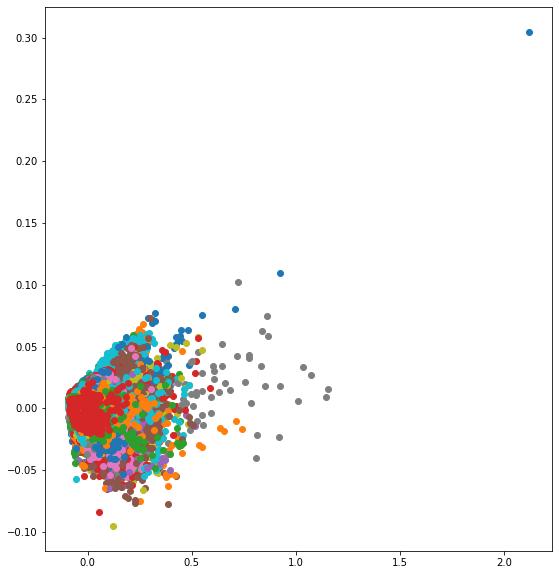

In [56]:
fig = plt.subplots(figsize=(20, 10))
counter = 0
print(pca.explained_variance_ratio_)
plt.subplot(1, 2, 2,
             #projection='3d'
             )
for cell in range(0, int(nb_cells[1]), 1):
    start = 0
    #end = nb_cells[1]
    x = []
    y = []
    fr =[]
    for t in t_range:

        lin = lineage[cell,t,:]
        rng = lin[~np.isnan(lin)].astype(int)
        
        x+=list(umap_data2[start+rng, 0])
        y+=list(umap_data2[start+rng, 1])
        fr+= [t]
        
        start += int(nb_cells[t+1])
        #end += nb_cells[t+2]
    #print(fr) 
    #ax.clear()
    plt.scatter(x, y)#, fr)
    #plt.xlim(-15, 15)
    #plt.ylim(-15, 15)
    #plt.legend("c="+str(cell))

In [57]:
def compute_grad_operator(vertices, neighbours):
    num_vertices = len(vertices)
    vertices = vertices
    nabla = np.zeros((num_vertices, num_vertices, vertices.shape[1]))
    for i in range(num_vertices):
        xi = i
        Ai = np.zeros((len(neighbours[i]), vertices.shape[1]))
        #print(Ai.shape)

        for j in range(len(neighbours[i])):
            xj = neighbours[i][j]
            xixj = vertices[xj] - vertices[xi]
            Ai[j,:] = -xixj
            if i==0:
                print(xi, xj, xixj)
        
        Ai_T = np.transpose(Ai)
        #if i==0:
        #    ATA = Ai_T @ Ai
        #    print(Ai_T)
        Gi = np.linalg.inv(Ai_T @ Ai) @ Ai_T
        
        for j in range(len(neighbours[i])):
            xj = neighbours[i][j]
            nabla[xi,xj,:] = Gi[:,j]
            nabla[xi,xi,:] -= Gi[:,j]

    return nabla

In [60]:
#from scipy.spatial import KDTree
from sklearn.neighbors import KDTree

start = int(nb_cells[1])
dim = Sf.shape[1]
#Sf = 10000 * Sf
H = np.zeros(Sf.shape[0])
T = np.zeros(Sf.shape[0])
#print(df_v[0:10])
tau = 2
for t in range(0, t_max):
    #print(int(nb_cells[t+1]))
    
    #if t<tau:
    t_range_start = max(0, t-tau)
    t_range_end = min(t_max, t+tau)

    start = int(cumul_cells[t_range_start])
    end = int(cumul_cells[t_range_end])

    points = Sf[start:end]
    velocities = df_v[start:end]

    kdtree = KDTree(points)
    
    num_neighbors = 5
    distances, neighbours = kdtree.query(points, k=num_neighbors)

    neighbours = np.array([np.array([j for j in neighbours[i] if j != i]) for i in range(len(neighbours))])
    #print(0, neighbours[0])

    nabla = compute_grad_operator(points, neighbours)
    #A = nabla
    #print(nabla.shape, dim)
    A = np.reshape(-nabla, (nabla.shape[0]*dim, nabla.shape[1]))
    b = np.reshape(velocities, (velocities.shape[0]*dim,))

    #print(A.shape)
    
    A_T = np.transpose(A)
    A_T_A = A_T@A
    #print(A_T_A)
    H_t = np.linalg.inv(A_T@A)@A_T@b

    t_start = int(cumul_cells[t])
    t_end = int(cumul_cells[t+1])

    H[t_start:t_end] = H_t[t_start-start:t_start-start+(t_end-t_start)]
    T[t_start:t_end] = np.ones(t_end - t_start)*t

    print(t, t_start, H_t[t_start-start])
    res = (A@H_t-b)
    res = np.dot(res, res)

    #print(len(points))
    #start += int(nb_cells[t+1])
    #print(H, res)    

0 64 [-84.02  -0.36 -11.38  -5.34  -0.9   -0.94  -0.31  -3.21  -7.23  -2.66
   0.51  -5.2   -4.27  -6.67  -0.87  -0.74  -7.54  -2.49  -8.14 -16.7
 -30.1 ]
0 65 [ 25.67  -5.18  41.05 -28.15   1.09 -10.98  -5.76  -2.17  -3.9   21.12
   4.69  -6.45  12.58  13.61  16.22  -0.39 -11.26  -3.98 -29.65 -65.03
  67.75]
0 32 [-73.93  -4.22  92.22 -50.9    6.5   11.65   1.84  13.51   7.72   2.87
  14.78  47.68  13.67 -29.08  13.     9.37   1.73  24.23  19.89  -8.92
  78.55]
0 1 [152.63  -4.74  43.99 -21.06   3.24  -7.28  -3.4   -3.47  -1.05  28.82
   7.2   -2.99  12.78  30.31  18.37   1.91  -7.98  -1.5  -16.43 -52.57
  48.68]
0 0 -6.43750699976813e-05
0 64 [-84.02  -0.36 -11.38  -5.34  -0.9   -0.94  -0.31  -3.21  -7.23  -2.66
   0.51  -5.2   -4.27  -6.67  -0.87  -0.74  -7.54  -2.49  -8.14 -16.7
 -30.1 ]
0 65 [ 25.67  -5.18  41.05 -28.15   1.09 -10.98  -5.76  -2.17  -3.9   21.12
   4.69  -6.45  12.58  13.61  16.22  -0.39 -11.26  -3.98 -29.65 -65.03
  67.75]
0 128 [-151.88   -3.    -25.67   -5.97   

KeyboardInterrupt: 

In [ ]:
""" #from scipy.spatial import KDTree
from sklearn.neighbors import KDTree

start = int(nb_cells[1])
dim = Sf.shape[1]
H = np.zeros(Sf.shape[0])
T = np.zeros(Sf.shape[0])
#print(Sf.shape)
for t in range(1, max):
    T[start:(start + int(nb_cells[t+1]))] = np.ones(int(nb_cells[t+1]))*t
    
points = Sf
velocities = df_v

kdtree = KDTree(points)

num_neighbors = 7
distances, neighbours = kdtree.query(points, k=num_neighbors)

neighbours = np.array([np.array([j for j in neighbours[i] if j != i]) for i in range(len(neighbours))])
nabla = compute_grad_operator(points, neighbours)
#A = nabla
#print(nabla.shape, dim, n)
A = np.reshape(-nabla, (nabla.shape[0]*dim, nabla.shape[1]))
b = np.reshape(velocities, (velocities.shape[0]*dim,))

print(A.shape)

A_T = np.transpose(A)
A_T_A = A_T@A
#print(A_T_A)
H = np.linalg.inv(A_T@A)@A_T@b
#H[start:(start + int(nb_cells[t+1]))] = H_t

#print(t, np.mean(H))
res = (A@H-b)
res = np.dot(res, res)

#print(len(points))
start += int(nb_cells[t+1])
#print(H, res)

     """

' #from scipy.spatial import KDTree\nfrom sklearn.neighbors import KDTree\n\nstart = int(nb_cells[1])\ndim = Sf.shape[1]\nH = np.zeros(Sf.shape[0])\nT = np.zeros(Sf.shape[0])\n#print(Sf.shape)\nfor t in range(1, max):\n    T[start:(start + int(nb_cells[t+1]))] = np.ones(int(nb_cells[t+1]))*t\n    \npoints = Sf\nvelocities = df_v\n\nkdtree = KDTree(points)\n\nnum_neighbors = 7\ndistances, neighbours = kdtree.query(points, k=num_neighbors)\n\nneighbours = np.array([np.array([j for j in neighbours[i] if j != i]) for i in range(len(neighbours))])\nnabla = compute_grad_operator(points, neighbours)\n#A = nabla\n#print(nabla.shape, dim, n)\nA = np.reshape(-nabla, (nabla.shape[0]*dim, nabla.shape[1]))\nb = np.reshape(velocities, (velocities.shape[0]*dim,))\n\nprint(A.shape)\n\nA_T = np.transpose(A)\nA_T_A = A_T@A\n#print(A_T_A)\nH = np.linalg.inv(A_T@A)@A_T@b\n#H[start:(start + int(nb_cells[t+1]))] = H_t\n\n#print(t, np.mean(H))\nres = (A@H-b)\nres = np.dot(res, res)\n\n#print(len(points))\nst

<ipython-input-29-9851e1146589>:32: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax.plot_surface(grid_x, grid_y, grid_h.T, cmap='viridis', alpha=0.7)


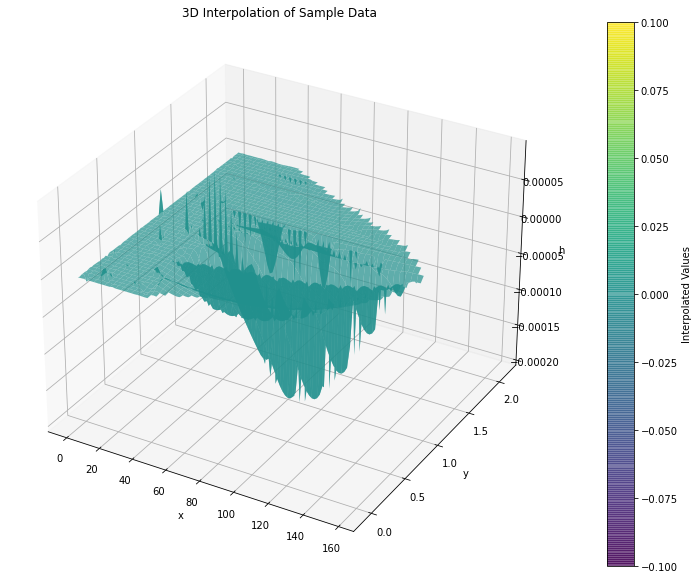

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

umap_data2[:,0]
umap_data2[:,1]

# Generate sample data
x = T
y = umap_data2[:,0]
data = np.random.rand(5, 10)

grid_x, grid_y = np.mgrid[np.min(x):np.max(x):100j, np.min(y):np.max(y):100j]

# Interpolate using griddata
grid_h = griddata((x, y), H, (grid_x, grid_y), method='cubic')

# 3D plot
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the original points
start = 0
#for t in t_range:
#    ax.scatter(x[start:(start + int(nb_cells[t+1]))], 
#               y[start:(start + int(nb_cells[t+1]))], 
#               H[start:(start + int(nb_cells[t+1]))], marker='o', label=f't={t}')
#    start += int(nb_cells[t+1])

# Surface plot of the interpolated grid
surf = ax.plot_surface(grid_x, grid_y, grid_h.T, cmap='viridis', alpha=0.7)

# Add a colorbar
fig.colorbar(surf, ax=ax, label='Interpolated Values')

ax.set_title('3D Interpolation of Sample Data')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('h')
#ax.legend()

plt.show()


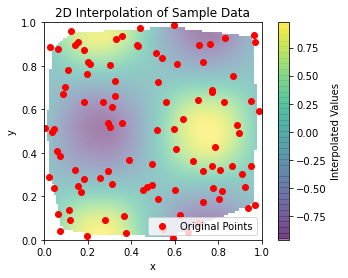

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Generate sample data
np.random.seed(42)
n = 100
x = np.random.rand(n)
y = np.random.rand(n)
h = np.sin(2 * np.pi * x) * np.cos(2 * np.pi * y)  # Example function values

# Define a grid for interpolation
grid_x, grid_y = np.mgrid[0:1:100j, 0:1:100j]

# Interpolate using griddata
grid_h = griddata((x, y), h, (grid_x, grid_y), method='cubic')

# Plot the original points and the interpolated grid
plt.scatter(x, y, c='red', marker='o', label='Original Points')
plt.imshow(grid_h.T, extent=(0, 1, 0, 1), origin='lower', cmap='viridis', alpha=0.5)
plt.colorbar(label='Interpolated Values')
plt.title('2D Interpolation of Sample Data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()